In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# 1. Các thư viện cần thiết
!pip install pydlm
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
from pydlm import dlm, trend, dynamic
import matplotlib.pyplot as plt
from pydlm import dlm, trend, seasonality, dynamic, autoReg, longSeason

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.8/63.8 kB 4.1 MB/s eta 0:00:00


In [3]:
# 2. Đọc file dữ liệu và chia train test validate theo tỉ lệ
df = pd.read_csv('/content/drive/MyDrive/Project_dataset/VPB.csv')
df = df[['Price','Low']]

df = df.dropna() # Drop missing values
df = df.reset_index(drop=True) # Reset the index

# Split the data into training, testing, and validating sets
train_size = int(0.6 * len(df))
test_size = int(0.3 * len(df))
val_size = len(df) - train_size - test_size

train_data = df[:train_size]
test_data = df[train_size:train_size+test_size]
val_data = df[train_size+test_size:]

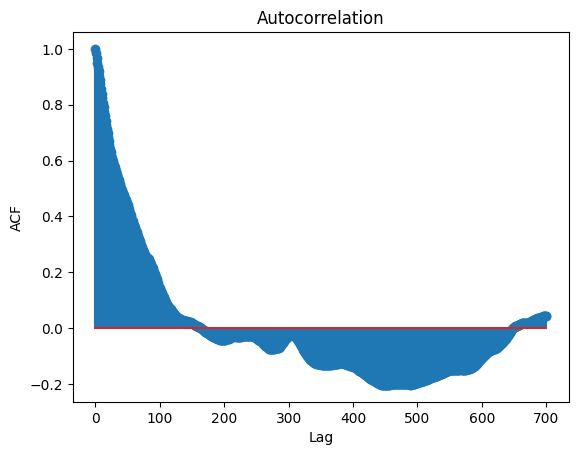

In [13]:
# 3. Tính toán ACF
import statsmodels.api as sm
acf = sm.tsa.stattools.acf(train_data['Price'], nlags= 700)

# Vẽ đồ thị ACF
plt.stem(acf)
plt.xlabel('Lag')
plt.ylabel('ACF')
plt.title('Autocorrelation')
plt.show()

In [5]:
# 4. Quá trình training
y_train = np.array(train_data['Price'])

x_train = []
for data in train_data['Low']:
  x_train.append([data])

model = dlm(y_train)
model = model + trend(1, discount=0.99, name='Trend', w=1e7)
model = model + dynamic(features=x_train, discount=1, name='Low')
model = model + autoReg(degree=3, discount=0.99, name='ar', w=1e7)
model = model + longSeason(period=12, stay=30, data=y_train, name='season', w=1e7)


model.fit()

Initializing models...
Initialization finished.
Starting forward filtering...
Forward filtering completed.
Starting backward smoothing...
Backward smoothing completed.


In [6]:
# 5. Quá trình testing
x_test= []
for data in test_data['Low']:
  x_test.append([data])

y_test = np.array(test_data['Price'])

y_pred = model.predictN(date = model.n-1, N=len(x_test),featureDict={'Low': x_test})
y_pred = y_pred[0]


In [7]:
# 6. Quá trình Validate
x_val= []
for data in val_data['Low']:
  x_val.append([data])

y_val = np.array(val_data['Price'])

y_pred_val = model.predictN(featureDict={'Low': x_val}, N = len(x_val))
y_pred_val = y_pred_val[0]


In [8]:
# 7. Đánh giá độ chính xác thuật toán
#RMSE
valid_rmse = np.sqrt(np.mean((y_pred_val - y_val)**2))
test_rmse = np.sqrt(np.mean((y_pred - y_test)**2))
print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)

#MAPE
valid_mape = np.mean(np.abs((y_val - y_pred_val) / y_val)) * 100
test_mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
print('Validation MAPE:', valid_mape)
print('Testing MAPE:', test_mape)

#MAE
valid_mae = np.mean(np.abs(y_pred_val - y_val))
test_mae = np.mean(np.abs(y_pred - y_test))
print('Validation MAE:', valid_mae)
print('Testing MAE:', test_mae)

Validation RMSE: 3866.6918083591195
Testing RMSE: 4686.824250795185
Validation MAPE: 20.519307391937488
Testing MAPE: 20.41573950529561
Validation MAE: 3835.520984409626
Testing MAE: 4071.9484651009607


In [9]:
#  8. Sử dụng linear regression dự báo cột Low 30 ngày tiếp theo
from sklearn.linear_model import LinearRegression

ln_model = LinearRegression()

ln_model.fit(np.array(train_data.index).reshape(-1,1), train_data['Low'])


# Predict the prices for the next 30 days
last_index =  df.index[-1]
last_data = pd.RangeIndex(start=last_index, stop=last_index+30, step=1)

index_next_30_days = np.array(range(last_index+1, last_index+31)).reshape(-1, 1)
low_next_30_days = ln_model.predict(index_next_30_days)

print(low_next_30_days)


[16784.20126458 16792.63827701 16801.07528945 16809.51230188
 16817.94931431 16826.38632675 16834.82333918 16843.26035161
 16851.69736405 16860.13437648 16868.57138892 16877.00840135
 16885.44541378 16893.88242622 16902.31943865 16910.75645108
 16919.19346352 16927.63047595 16936.06748838 16944.50450082
 16952.94151325 16961.37852568 16969.81553812 16978.25255055
 16986.68956298 16995.12657542 17003.56358785 17012.00060028
 17020.43761272 17028.87462515]


In [10]:
# 9. Dự báo giá cổ phiếu 30 ngày tiếp theo
x_next_30_days = []
for data in low_next_30_days:
  x_next_30_days.append([data])

y_next_30_days = model.predictN(N = 30, featureDict={'Low': x_next_30_days})
y_next_30_days = y_next_30_days[0]
print(y_next_30_days)


[20656.737478899842, 21687.606185049823, 21066.858638536694, 21079.058991099435, 21081.858576163057, 21076.43058456665, 21096.520108916866, 21110.838282551875, 21128.10424927195, 21145.32923902458, 21162.590707484047, 21179.957512019846, 21197.306507044505, 21214.669327200852, 21232.032194509433, 21249.395551941518, 21266.75936548208, 21284.123139476407, 21301.48697945355, 21318.850821763255, 21336.214667807075, 21353.578515953854, 21370.942364128903, 21388.306212627278, 21405.67006115113, 21423.033909699407, 21440.39775825808, 21457.761606817956, 21475.125455379464, 21492.489303941187]


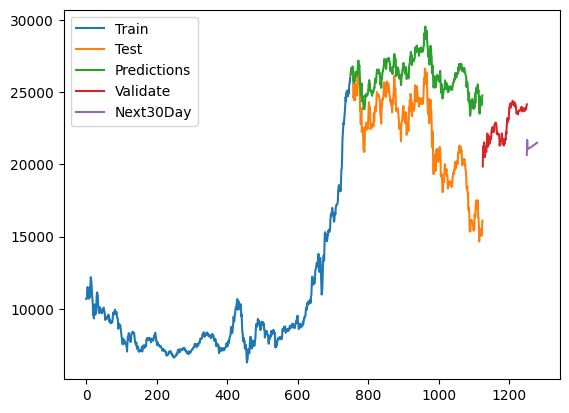

In [11]:
# 10. Vẽ hình
plt.plot(train_data.index, train_data['Price'])
plt.plot(test_data.index, test_data['Price'])
plt.plot(test_data.index, y_pred)
plt.plot(val_data.index, y_pred_val)
plt.plot(last_data,y_next_30_days)
plt.legend(['Train', 'Test', 'Predictions','Validate','Next30Day'])
plt.show()